# Generation of the Hopf Fibration with PYNQ
## Using a Hopf Map Custom IP

#### Created by Group A : Finlay Harris, Morgan McFarlane, James Petrie

Purpose: <br>Submission for University of Strathclyde: EE315 Further VHDL and FPGA Design <br>

Aim:<br> To generate an artist representation of the Hopf Fibration by passing off computationally challenging sections to the PL section of the SoC to process sections in parallel. The Hopf Fibration generated using the PL should be the same as the one generated in only software. This model utilises a custom IP designed in system generator that calculates the Hopf Map based on an angle input.<br>

Decription: <br> This notebook contains the software and hardware implementation of an artist representation of the Hopf Fibration using a linear algebraic approach. The hardware approach makes use of a custom IP that calculates the Hopf Map (the 4D Coordinates, then converts them to 3D) and plots a representation of the Hopf Fibration based off these coordinates. The two method is timed to compare to the methods using trigonmetry and AXI. <br>

### What is the Hopf Fibration?

The Hopf fibration is a fascinating and fundamental concept in the field of topology, a branch of mathematics. It was discovered by Heinz Hopf in 1931. This fibration is an example of a map from one sphere to another sphere of lower dimension, specifically from a 3-dimensional sphere \( S^3 \) to a 2-dimensional sphere \( S^2 \).

The Hopf fibration is significant because it is one of the first discovered examples of a fiber bundle where the total space and the base space are both spheres but of different dimensions. It illustrates a deep geometric and topological structure, showing that \( S^3 \) can be thought of as a union of circles (1-dimensional spheres), each of which is parameterized by points on \( S^2 \).

This concept has profound implications in various fields of mathematics and physics, particularly in the study of complex numbers and quaternionic structures. The fibers in the Hopf fibration are circles, and each fiber is linked with every other fiber exactly once, demonstrating an elegant intertwining structure.

![Hopf Fibration Visualization](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/Hopf_Fibration.png/1200px-Hopf_Fibration.png)



### Include Relevant Libraries:
- **numpy** - To handle arrays in python.
- **matplotlib** and **mpl_toolkits.mplot3d** - For plotting 3D visuals.
- **PYNQ overlay** and **allocate** - To enable interaction with programmable logic (PL) on PYNQ-enabled devices.
- **time** - To record the elapsed time of processes.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pynq import allocate
from pynq import Overlay
import time

### Generating Inputs for Software & Hardware

The inputs to the system are three angles, each with a specific range and purpose:

1. **Alpha**: This angle typically represents a rotation around the vertical axis. In the context of this system, it ranges from $ 0$ to  $4pi$  radians, allowing for two full rotations, which could be necessary for certain types of symmetry or periodic functions.

2. **Phi**: Often denoted as the azimuthal angle in spherical coordinates, it represents a rotation around the horizontal axis. For our system,  $phi $ spans from $ 0 $ to $pi $ radians, corresponding to a semi-circle from one pole to the other.

3. **Theta**: This is the polar or inclination angle, measuring the angle from the zenith direction. In our setup, $theta$  varies between $ 0 $ and 2$pi $ radians, which covers a complete rotation around the axis, similar to latitude in geographic coordinates.

Each angle is sampled into 50 points, resulting in a set of 50 unique values for $alpha$, $phi$ , and $theta$, which are used as inputs for the system to define points on a sphere in three-dimensional space or to control the orientation of a physical device in the case of hardware applications.


In [3]:
# Function to generate an array of angle samples based off the range given in the parameters
# Parameters: start- start of range, end - end of range, num_points - number of elements in array
def generate_angle_array(start, end, num_points):
    return np.linspace(start, end, num=num_points)

In [4]:
# Define the angles
num_points = 50
alpha_array = generate_angle_array(0, 4*np.pi, num_points)
phi_array = generate_angle_array(0, np.pi, num_points)
theta_array = generate_angle_array(0, 2*np.pi, num_points)

<IPython.core.display.Javascript object>


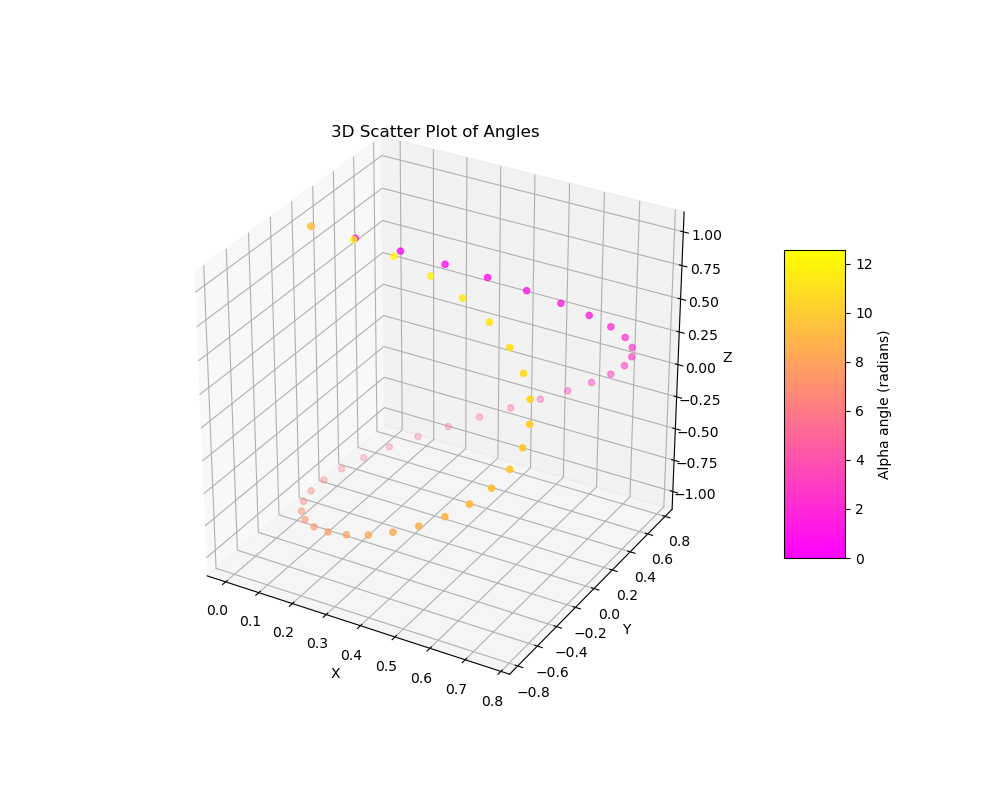

In [5]:
# Generate a 3D Plot to visualise angles generated
##################################################

# Transform spherical coordinates to Cartesian coordinates for the plot
x = np.sin(theta_array) * np.cos(phi_array)
y = np.sin(theta_array) * np.sin(phi_array)
z = np.cos(theta_array)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(x, y, z, c=alpha_array, cmap='spring')

# Colorbar to show the alpha values
colorbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
colorbar.set_label('Alpha angle (radians)')

# Set labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set title
ax.set_title('3D Scatter Plot of Angles')

# Show the plot
plt.show()

### Software Implementation
##### Generate the Hopf Map:

In [6]:
# Function to calculate the Hopf Map
####################################

def hopf_map(alpha, phi, theta):
    """
    Parametrise the 3-sphere in 4D space using the Hopf fibration.
    
    :param alpha: angle ranging from 0 to 4π
    :param phi: angle ranging from 0 to 2π
    :param theta: angle ranging from 0 to 2π
    :return: tuple (X0, X1, X2, X3) representing a point in 4D space
    """
   

    X0 = np.cos((alpha + phi) / 2) * np.sin(theta / 2)
    X1 = np.sin((alpha + phi) / 2) * np.sin(theta / 2)
    X2 = np.cos((alpha - phi) / 2) * np.cos(theta / 2)
    X3 = np.sin((alpha - phi) / 2) * np.cos(theta / 2)
    
    return X0, X1, X2, X3



##### Perform Stereographic Projection:

In [7]:
# Function to perform stereographic projection (drop a dimension)
#################################################################

def stereographic_projection(X0, X1, X2, X3):
    """
    Parametrise the 4D Coordinates to 3D.
    
    :param X0,X1,X2,X3: 4D Coordinates
    :return: x,y,z representing a point in 3D space
    """

    # Avoid division by zero in case X3 is 1
    denom = 1 - X3
    # Use np.where to handle near-zero values
    denom = np.where(np.isclose(denom, 0), np.finfo(float).eps, denom)
    
    x = X0 / denom
    y = X1 / denom
    z = X2 / denom
    
    return x, y, z



##### Generating the Software Results:

In [8]:
# Function to plot defined number of Fibres on the Hopf Fibration
#################################################################

def visualise_hopf_fibration(num_fibers=200, num_points_per_fiber=1000):
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Colour map
    colours = plt.cm.twilight_shifted(np.linspace(0, 1, num_fibers))
    
    start = time.time()

    for i in range(num_fibers):
        phi = 2 * np.pi * (i / num_fibers)  # Constant for each fiber
        alpha = np.linspace(0, 4 * np.pi, num_points_per_fiber)
        theta = np.linspace(0, 2 * np.pi, num_points_per_fiber)  # Varies along each fiber 
        
        # Calculate 4D Coordinates
        X0, X1, X2, X3 = hopf_map(alpha, phi, theta)
        # Drop a dimension
        x, y, z = stereographic_projection(X0, X1, X2, X3)
        
        # Find the maximum absolute coordinate from x, y, z
        max_coord = np.max([np.abs(x).max(), np.abs(y).max(), np.abs(z).max()])

        # Normalize the coordinates so that all are within the range [-1, 1]
        x_normalised = x / max_coord
        y_normalised = y / max_coord
        z_normalised = z / max_coord
        ax.plot(x_normalised, y_normalised, z_normalised, color=colours[i], alpha=0.6)
        
    elapsed_time = time.time() - start
    print("Total Time to calcualte 4D Coordinates & perform Stereographic Projection = ", elapsed_time, " seconds" )

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Hopf Fibration Visualisation')
    plt.show()

<IPython.core.display.Javascript object>


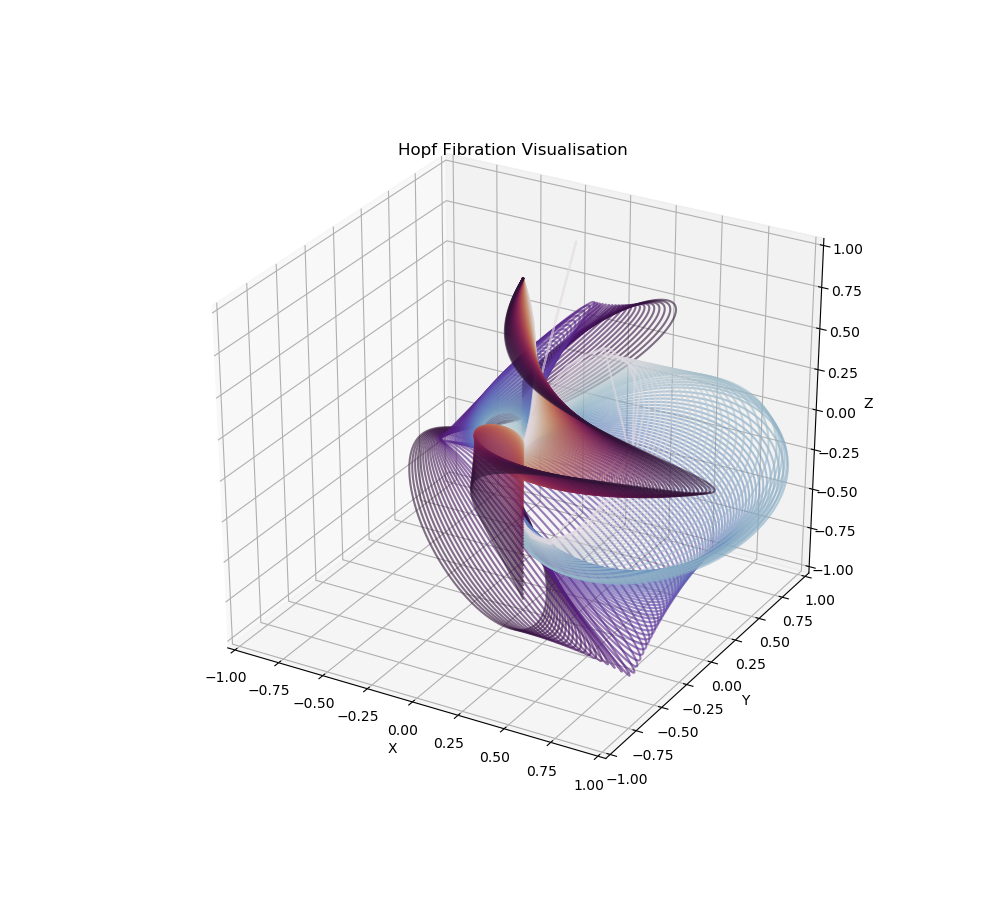

Total Time to calcualte 4D Coordinates & perform Stereographic Projection =  4.268665075302124  seconds
TotalTime to generate =  4.635736703872681  seconds


In [9]:
start = time.time()

# Generate and visualise the Hopf fibration
visualise_hopf_fibration()

elapsed_time = time.time() - start
print("TotalTime to generate = ", elapsed_time, " seconds" )

### Hardware implementation:
##### Import Hopf Fibration hardware:
The hardware was created using model composer and exported to Vivado to generate a bitstream and hardware handoff file.

In [10]:
# Load the PYNQ overlay
overlay = Overlay('HopfFibration.bit')

hopfFibration = overlay.hopfmapequation_0

##### Hardware driver:

In [13]:
from pynq import DefaultIP
from pynq import allocate


# Function that defines the Hardware Driver
###########################################

class AddDriver(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)
    bindto = ['User_Company:SysGen:hopfmapequation:1.0']
    def add(self, z1_real, z1_imag, z2_real, z2_imag):
        a = float_to_fixed(z2_real)
        b = float_to_fixed(z2_imag)
        c = float_to_fixed(z1_real)
        d = float_to_fixed(z2_imag)
        self.write(0x00, a) 
        self.write(0x04, b)
        self.write(0x08, c)
        self.write(0x0C, d)
        return self.read(0x10), self.read(0x14), self.read(0x18)


##### Data Conversion Funtions:
Communication between software and hardware transfers at 32 bits at a time; to allow for correct range and precision, the IP is expecting an input of a fixed point, signed 32 bit number with 0 fractional bits. <br> The float_to_binary function shows this conversion. 

When recieved, this fixed point formatting needs to be scaled back to a float to enable further calculations.

In [14]:
def float_to_fixed(num, integer_bits=2, fractional_bits=6, scaling_factor=64):
    # Apply scaling
    num_scaled = num * scaling_factor
    # Convert the float to a fixed-point representation
    fixed_num = int(round(num_scaled))
    # Clamp the value to the maximum allowed by the bit sizes
    max_val = 2 ** (integer_bits + fractional_bits - 1) - 1
    min_val = -2 ** (integer_bits + fractional_bits - 1)
    fixed_num = max(min(fixed_num, max_val), min_val)
    return fixed_num

def complex_to_fixed(z, fractional_bits=6):
    # Scale the real and imaginary parts by 2^fractional_bits
    # and convert to integers
    return int(np.real(z) * (1 << fractional_bits)), int(np.imag(z) * (1 << fractional_bits))


# Function to convert fixed-point results back to floating-point
def fixed_to_float(fixed_val, fractional_bits=6, scaling_factor=64):
    # Convert the fixed-point number back to a float
    return fixed_val / (1 << fractional_bits) / scaling_factor


##### Generate results from hardware:
###### Generate the Hopf Map:

In [15]:
###########################################################################
# Function that generates the random complex numbers meeting constraint of:
                # | z1 |^2 + | z2 |^2 = 1
###########################################################################

def sample_spherical_coordinates(num_points):
    # phi ranges from 0 to pi/2
    phi = np.arccos(1 - 2 * np.random.rand(num_points))
    # theta1 and theta2 range from 0 to 2*pi
    theta1 = 2 * np.pi * np.random.rand(num_points)
    theta2 = 2 * np.pi * np.random.rand(num_points)
    
    # Convert to Cartesian coordinates 
    r1 = np.cos(phi)
    r2 = np.sin(phi)
    z1_real = r1 * np.cos(theta1)
    z1_imag = r1 * np.sin(theta1)
    z2_real = r2 * np.cos(theta2)
    z2_imag = r2 * np.sin(theta2)
    
    # Combine to form complex numbers
    z1 = z1_real + 1j * z1_imag
    z2 = z2_real + 1j * z2_imag
    
    return z1, z2

In [16]:
# Generate 50 samples of points on S^3
num_points = 50
z1, z2 = sample_spherical_coordinates(num_points)

<IPython.core.display.Javascript object>


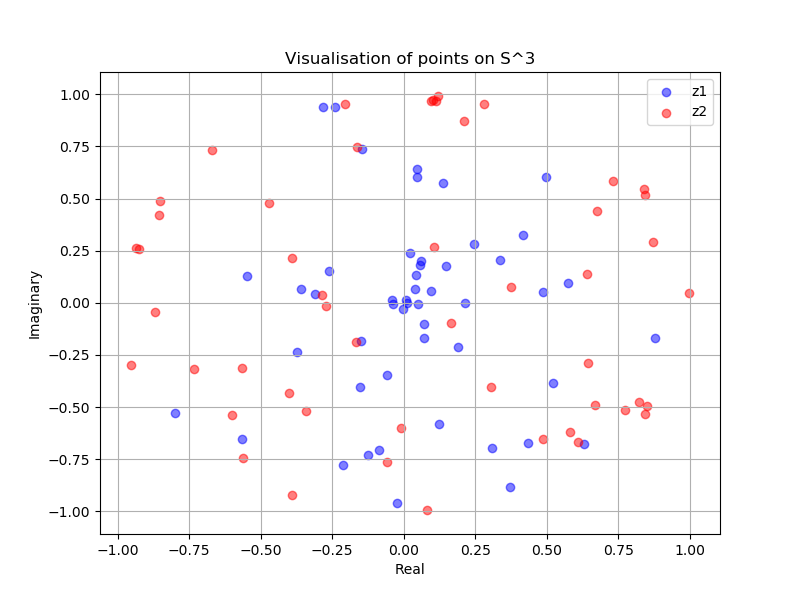

In [17]:
# Plot the real and imaginary parts of z1 and z2 to visulise points on S^3
plt.figure(figsize=(8, 6))
plt.scatter(np.real(z1), np.imag(z1), label='z1', color='blue', alpha=0.5)
plt.scatter(np.real(z2), np.imag(z2), label='z2', color='red', alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Visualisation of points on S^3')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def process_point(z1_real, z1_imag, z2_real, z2_imag, hopfFibration, scaling_factor=64):
    # Scale and convert the real and imaginary parts
    z1_real_fixed = float_to_fixed(z1_real, scaling_factor=scaling_factor)
    z1_imag_fixed = float_to_fixed(z1_imag, scaling_factor=scaling_factor)
    z2_real_fixed = float_to_fixed(z2_real, scaling_factor=scaling_factor)
    z2_imag_fixed = float_to_fixed(z2_imag, scaling_factor=scaling_factor)
    # Write to the FPGA
    hopfFibration.write(0x00, z2_real_fixed) 
    hopfFibration.write(0x04, z2_imag_fixed)
    hopfFibration.write(0x08, z1_real_fixed)
    hopfFibration.write(0x0C, z1_imag_fixed)
    # Read the result
    x = hopfFibration.read(0x10)
    y = hopfFibration.read(0x14)
    z = hopfFibration.read(0x18)
    # Convert the result back to float and unscale
    x_float = fixed_to_float(x, scaling_factor=scaling_factor)
    y_float = fixed_to_float(y, scaling_factor=scaling_factor)
    z_float = fixed_to_float(z, scaling_factor=scaling_factor)
    return x_float, y_float, z_float


In [19]:
start = time.time()

results = []
for i in range(num_points):
    result = process_point(
        np.real(z1[i]), 
        np.imag(z1[i]), 
        np.real(z2[i]), 
        np.imag(z2[i]),
        hopfFibration,  
        scaling_factor=64
    )
    results.append(result)
    
elapsed_time = time.time() - start
print("Total Time to calcualte Hopf Map = ", elapsed_time, " seconds" )

Total Time to calcualte Hopf Map =  0.08693122863769531  seconds


In [20]:
# Convert the FPGA output to floating-point and reshape for visualisation
fpga_results_float = [(fixed_to_float(x), fixed_to_float(y), fixed_to_float(z)) for x, y, z in results]
points_array = np.array(fpga_results_float)  # Convert list of tuples to numpy array

In [21]:
# Function to scale up the z values
def scale_up_z(z_value):
    # 2^22 = 4194304
    return z_value * 4194304

# Scale the z values
points_array = np.array([(x, y, scale_up_z(z)) for x, y, z in results])

print(points_array)


[[2.61544e+05 1.41600e+03 1.95584e+05]
 [2.81600e+03 2.59792e+05 1.97632e+05]
 [2.50288e+05 2.51392e+05 2.49856e+05]
 [1.27200e+03 1.48560e+04 2.32448e+05]
 [3.16800e+03 7.12000e+03 2.03776e+05]
 [1.13840e+04 2.63200e+03 2.15040e+05]
 [2.48184e+05 2.61544e+05 2.27328e+05]
 [2.52944e+05 2.58616e+05 2.08896e+05]
 [2.60632e+05 5.84000e+02 1.96608e+05]
 [2.54688e+05 5.07200e+03 2.06848e+05]
 [1.13840e+04 1.07120e+04 2.42688e+05]
 [2.60176e+05 1.18400e+03 1.95584e+05]
 [1.52000e+03 1.12800e+04 2.15040e+05]
 [2.54776e+05 2.47960e+05 2.44736e+05]
 [2.97600e+03 2.47936e+05 3.17440e+04]
 [7.16000e+03 1.39200e+04 2.40640e+05]
 [5.96000e+03 2.58296e+05 2.02752e+05]
 [6.64000e+03 2.60784e+05 2.02752e+05]
 [2.52408e+05 1.32640e+04 6.14400e+03]
 [2.45976e+05 2.62008e+05 2.49856e+05]
 [1.31920e+04 9.08000e+03 1.74080e+04]
 [5.82400e+03 2.50592e+05 2.20160e+05]
 [3.04000e+02 9.76000e+02 1.96608e+05]
 [3.40800e+03 2.66400e+03 1.98656e+05]
 [2.60688e+05 2.55312e+05 2.02752e+05]
 [5.76000e+02 2.61696e+05

In [23]:
# Function to visualise and generate the Hopf Fibration using Hardware
######################################################################

# Assuming you have the hopfFibration IP correctly initialized elsewhere in your code

def visualise_hopf_fibration2(hopfFibration, num_fibers=200, num_points_per_fiber=1000):
    fig = plt.figure(figsize=(10, 9))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.cm.twilight_shifted(np.linspace(0, 1, num_fibers))
    
    x_all = np.zeros((num_fibers * num_points_per_fiber))
    y_all = np.zeros_like(x_all)
    z_all = np.zeros_like(x_all)
    
    start = time.time()
    
    for i in range(num_fibers):
        # Calculate the constant phi angle for this fiber
        phi = 2 * np.pi * i / num_fibers
        
        # Generate the alpha and theta values for this fiber
        alpha = np.linspace(0, 4 * np.pi, num_points_per_fiber)
        theta = np.linspace(0, 2 * np.pi, num_points_per_fiber)
        
        for j in range(num_points_per_fiber):
            # Use the process_point function to interact with the hardware and get the x, y, z coordinates
            x, y, z = process_point(
                np.cos(alpha[j]), np.sin(alpha[j]),
                np.cos(theta[j]), np.sin(theta[j]),
                hopfFibration
            )
            
            # Store the coordinates
            idx = i * num_points_per_fiber + j
            x_all[idx] = x
            y_all[idx] = y
            z_all[idx] = z
    
    # Normalise the coordinates
    max_coord = np.max(np.abs([x_all, y_all, z_all]))
    x_all /= max_coord
    y_all /= max_coord
    z_all /= max_coord
    
    # Plotting each fiber
    for i in range(num_fibers):
        idx_start = i * num_points_per_fiber
        idx_end = idx_start + num_points_per_fiber
        ax.plot(x_all[idx_start:idx_end], y_all[idx_start:idx_end], z_all[idx_start:idx_end], color=colors[i], alpha=0.6)
    
    elapsed_time = time.time() - start
    print("Total time to calculate 4D Coordinates & perform Stereographic Projection = ", elapsed_time, " seconds")
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title('Hopf Fibration Visualization')
    plt.show()


<IPython.core.display.Javascript object>


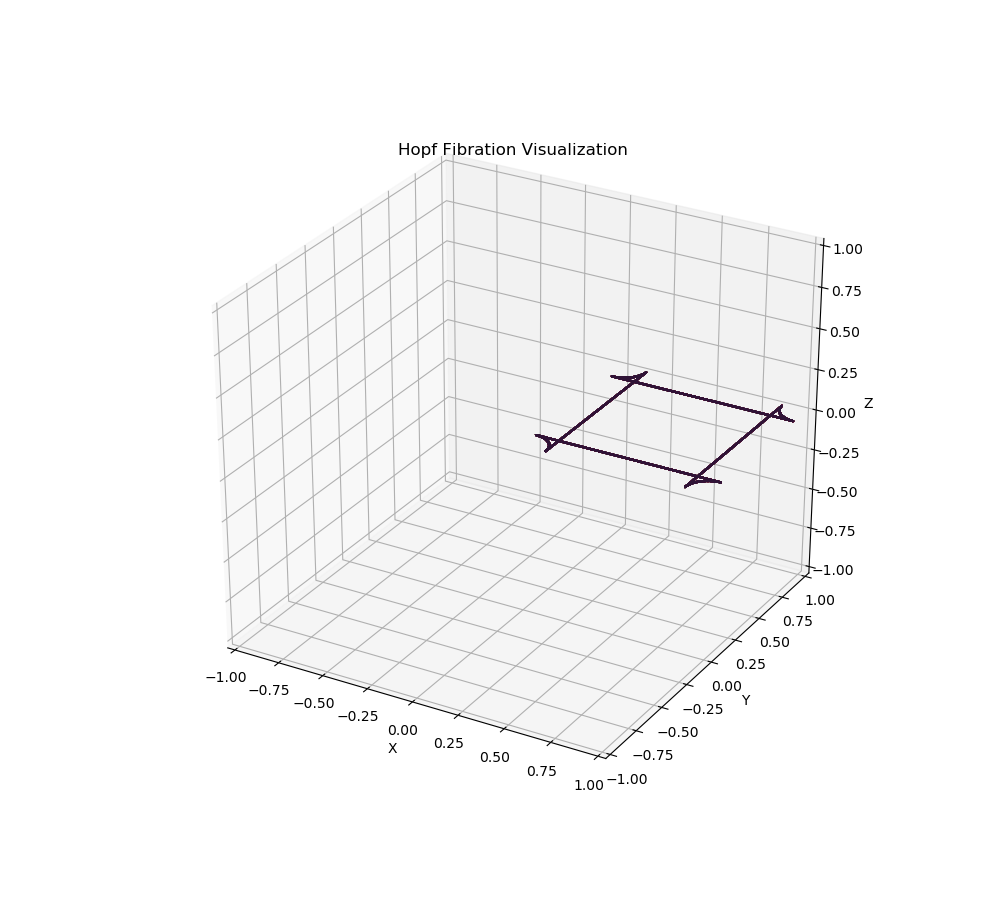

Total time to calculate 4D Coordinates & perform Stereographic Projection =  107.55723547935486  seconds
Total Time to generate =  108.25279140472412  seconds


In [28]:
from pynq import Overlay

# Load FPGA bitstream 
overlay = Overlay('HopfFibration.bit')

hopfFibration = overlay.hopfmapequation_0

start = time.time()
visualise_hopf_fibration2(hopfFibration, num_fibers=200, num_points_per_fiber=1000)
elapsed_time = time.time() - start
print("Total Time to generate = ", elapsed_time, " seconds")


# Discussion & Conclusions

## Project Overview

The project aimed to generate an artistic representation of the Hopf Fibration using a PYNQ System on Chip (SoC), harnessing the computational capabilities of the Programmable Logic (PL) to parallelise the rendering. This complex topological structure was approached through both hardware and software implementations, with a focus on comparing their efficiencies and accuracies.

## Hardware vs. Software Performance

### Hardware Implementation:

Utilising the PL and AXI-Lite to perform a linear algebraic approach to calculating the Hopf Map facilitated rapid computations, demonstrating the potential of hardware acceleration in complex mathematical visualisations.

### Software Implementation:

Although typically slower due to its sequential processing nature, the software approach provided greater flexibility and was crucial for benchmarking the accuracy of the hardware implementation. In this case, it was much faster than the hardware but that is believed to be due to an incorrect implementation of the Hopf Map, as well as the data being represented inaccurately due to the limitations of 32 bits for AXI-Lite.


### Challenges and Innovations

Our data transmission phase highlighted scalability issues, pointing to potential improvements in bus architecture. The fixed-point arithmetic required by FPGA computations also introduced limitations that affected the accuracy.

### Forward Thinking

Moving forward, enhancing the data transmission efficiency by implementing an AXI-Stream interface could potentially alleviate some of the current bottlenecks. Moreover, exploring alternative computational approaches could yield a more precise visualisation of the Hopf Fibration.

In conclusion, while the project did not achieve the anticipated acceleration in generating the Hopf Fibration, it highlighted the potential benefits and current limitations of FPGA applications in mathematical visualisation tasks.

### Closing Notes

In essence, this foray into the visualization of mathematical constructs using FPGAs has not only expanded our understanding of computational applications but also laid the groundwork for future explorations. As we stand on the shoulders of this project, the view ahead is one of potential and promise for those who follow.
